<a href="https://colab.research.google.com/github/tienpm/CS114.K21.KHTN/blob/master/18520166_PhamManhTien_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name: Pham Manh Tien - Student ID: 18520166**

**Class ID: CS114.K21.KHTN**

**UIT-VNU**

#  **I. DESCRIPTION**
#### Input: Input a flower image
#### Output: What flowers of input image?
##### Dataset is collected Flowers-17 from University of Oxford which descripbed in this link: http://www.robots.ox.ac.uk/~vgg/data/flowers/17/
##### Dataset had 17 category flower dataset with 80 images for each class. The flowers chosen are some common flowers in the UK. The images have large scale, pose and light variations and there are also classes with large varations of images within the class and close similarity to other classes.

In [ ]:
# Install enviroment
!pip install mahotas
!pip install h5py

     |████████████████████████████████| 5.7MB 2.5MB/s 


# **II. PRE-PROCESSING DATA**

In [ ]:
#-----------------------------------------
# DOWNLOAD AND ORGANIZE FLOWERS17 DATASET
#-----------------------------------------
import os
import glob
import datetime
import tarfile
import urllib.request
import cv2

def download_dataset(filename, url, work_dir):
  if not os.path.exists(filename):
    print("[INFO] Downloading flowers17 dataset....")
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    print("[INFO] Succesfully downloaded " + filename + " " + str(statinfo.st_size) + " bytes.")
    untar(filename, work_dir)

def jpg_files(members):
  for tarinfo in members:
    if os.path.splitext(tarinfo.name)[1] == ".jpg":
      yield tarinfo

def untar(fname, path):
  tar = tarfile.open(fname)
  tar.extractall(path=path, members=jpg_files(tar))
  tar.close()
  print("[INFO] Dataset extracted successfully.")


In [ ]:
flowers17_url  = "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/"
flowers17_name = "17flowers.tgz"
train_dir      = os.path.join(os.getcwd(),"dataset")

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

# Download and tar dataset
download_dataset(flowers17_name, flowers17_url, train_dir)

# Rename directory in dataset "jpg" -> "train"
if os.path.exists(train_dir + "/jpg"):
    print("Access dataset successfully")
    print("Rename ...")
    os.rename(train_dir + "/jpg", train_dir + "/train")
    print("Rename successfully")

[INFO] Downloading flowers17 dataset....
[INFO] Succesfully downloaded 17flowers.tgz 60270631 bytes.
[INFO] Dataset extracted successfully.
Access dataset successfully
Rename ...
Rename successfully


In [ ]:
# take all the images from the dataset
image_paths = sorted(glob.glob(train_dir + "/train/*.jpg"))
print("Number of image in dataset: {}".format(len(image_paths)))
print(image_paths)

In [ ]:
# Get the class label limit
class_limit = 17
# flower17 class names
class_names = ["daffodil", "snowdrop", "lilyvalley", "bluebell", "crocus",
             "iris", "tigerlily", "tulip", "fritillary", "sunflower", 
             "daisy", "coltsfoot", "dandelion", "cowslip", "buttercup",
             "windflower", "pansy"]
 # variables to keep track
label = 0
i = 0
j = 80
for x in range(1, class_limit+1):
    # create a folder for that class
    os.makedirs(train_dir + "/train/" + class_names[label])
    
    # get the current path
    cur_path = train_dir + "/train/" + class_names[label] + "/"
    
    # loop over the images in the dataset
    for index, image_path in enumerate(image_paths[i:j], start=1):
      original_path   = image_path
      image_file_name = str(index) + ".jpg"
      os.rename(original_path, cur_path + image_file_name)
    
    i += 80
    j += 80
    label += 1

# **III. FEATURE EXTRACTION**

In [ ]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class = 80
fixed_size       = tuple((500, 500))
output_path = os.path.join(train_dir, "output")
if not os.path.exists(output_path):
  os.mkdir(output_path)
train_path = os.path.join(train_dir, "train")
h5_data          = os.path.join(output_path, "data.h5")
h5_labels        = os.path.join(output_path, "labels.h5")
bins             = 8

In [ ]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [ ]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    return hist.flatten()

In [ ]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


In [ ]:
# empty lists to hold feature vectors and labels
global_features = []
labels          = []
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"
        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: bluebell
[STATUS] processed folder: buttercup
[STATUS] processed folder: coltsfoot
[STATUS] processed folder: cowslip
[STATUS] processed folder: crocus
[STATUS] processed folder: daffodil
[STATUS] processed folder: daisy
[STATUS] processed folder: dandelion
[STATUS] processed folder: fritillary
[STATUS] processed folder: iris
[STATUS] processed folder: lilyvalley
[STATUS] processed folder: pansy
[STATUS] processed folder: snowdrop
[STATUS] processed folder: sunflower
[STATUS] processed folder: tigerlily
[STATUS] processed folder: tulip
[STATUS] processed folder: windflower
[STATUS] completed Global Feature Extraction...


In [ ]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] feature vector size (1360, 532)
[STATUS] training Labels (1360,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [ 0  0  0 ... 16 16 16]
[STATUS] target labels shape: (1360,)
[STATUS] end of training..


# **IV. MODEL DESCRIPTION**

In [ ]:
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

num_trees = 100
test_size = 0.10
seed      = 9
test_path  = os.path.join(train_dir, "test")
if not os.path.exists(test_path):
  os.mkdir(test_path)
scoring = "accuracy"
# **IV. CHOOSE MODEL, TRAINING AND FINE TUNING**
# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))
models.append(('LinearSVC', LinearSVC(C=1, loss='squared_hinge', penalty='l2',multi_class='ovr')))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (1360, 532)
[STATUS] labels shape: (1360,)
[STATUS] training started...


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (1224, 532)
Test data   : (136, 532)
Train labels: (1224,)
Test labels : (136,)


LR: 0.513968 (0.046249)
LDA: 0.448534 (0.031931)
KNN: 0.357044 (0.025681)
CART: 0.481214 (0.034663)
RF: 0.640457 (0.024562)
NB: 0.362735 (0.029703)
SVM: 0.492710 (0.040263)
LinearSVC: 0.500846 (0.052319)


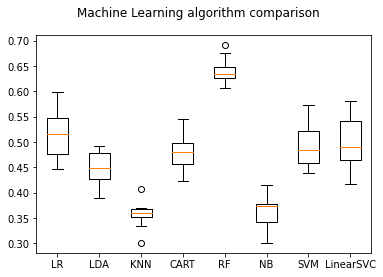

In [ ]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

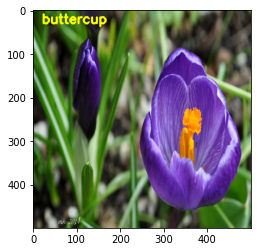

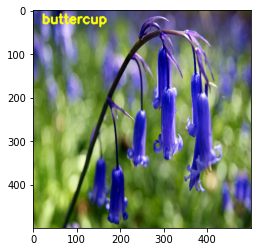

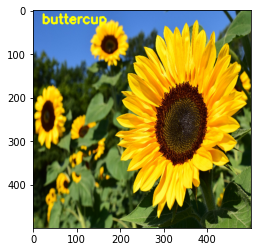

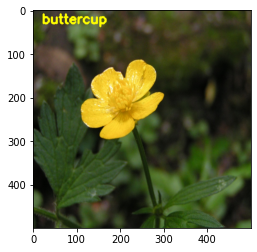

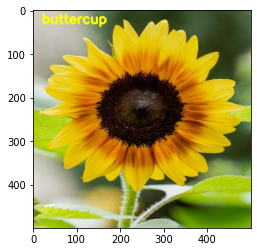

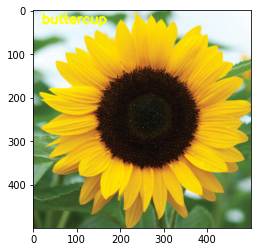

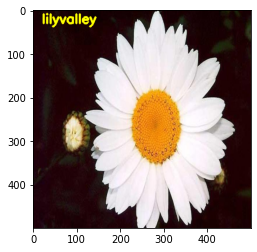

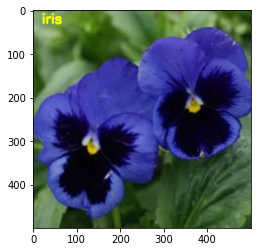

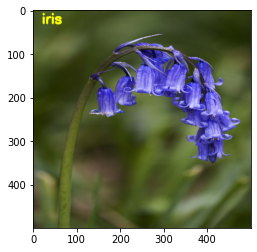

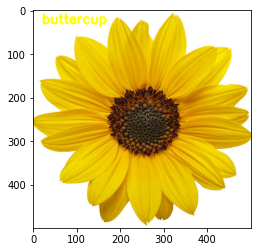

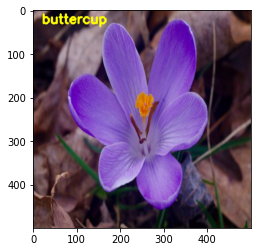

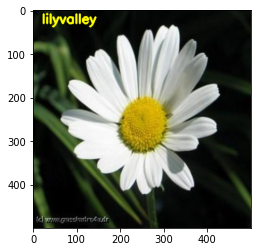

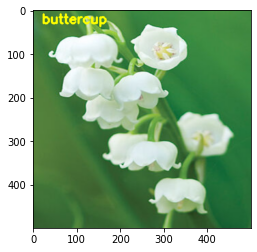

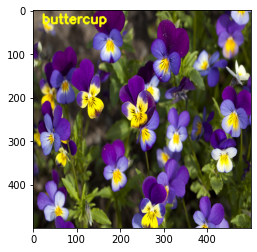

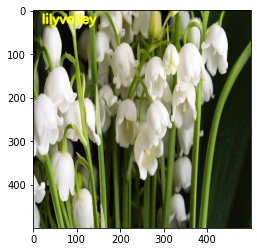

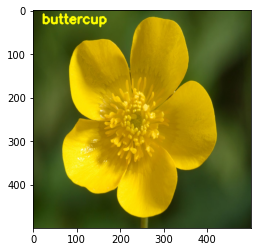

In [ ]:
#-----------------------------------
# TESTING BEST ACCURACY MODEL 
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments]).reshape(-1,1)

    # scale features in the range (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_feature)

    # predict label of test image
    prediction = clf.predict(rescaled_feature.reshape(1, -1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# **V. EVALUATION AND CONCLUSIONS**
- The model have only predicted 3 class flower: buttercup, lilyvaley and iris
- The result isn't meaningless and can't apply in practice 